# **ASkDAgger**: Active Skill-level Data Aggregation for Interactive Imitation Learning

This Colab tutorial is a code example for the paper *ASkDAgger: Active Skill-level Data Aggregation for Interactive Imitation Learning*.
This code example will show how we can train a robot novice to perform a pick-and-place task using ASkDAgger.

### Overview of ASkDAgger

<img src="https://raw.githubusercontent.com/askdagger/askdagger.github.io/main/static/images/askdagger_overview.png" width="100%">

**Figure 1**: The Active Skill-level Data Aggregation (ASkDAgger) framework consists of three main components: S-Aware Gating (SAG), Foresight Interactive Experience Replay (FIER), and Prioritized Interactive Experience Replay (PIER).
In this interactive imitation learning framework, we allow the novice to say: "*I plan to do this, but I am uncertain.*"
The uncertainty gating threshold is set by SAG to track a user-specified metric: sensitivity, specificity, or minimum system success rate.
Teacher feedback is obtained with FIER, enabling demonstrations through validation, relabeling, or teacher demonstrations.
Lastly, PIER prioritizes replay based on novice success, uncertainty, and demonstration age.

### Notebook Settings

First you will need to connect to a GPU runtime. You can do this by going to **Edit** -> **Notebook settings** -> **Hardware accelerator** and choose a GPU.

In [ ]:
# @title Clone ASkDAgger repository

!git clone --depth=1 -b colab https://github.com/askdagger/askdagger_cliport /content/askdagger_cliport


Cloning into '/content/askdagger_cliport'...
remote: Enumerating objects: 249, done.
remote: Counting objects: 100% (249/249), done.
remote: Compressing objects: 100% (197/197), done.
remote: Total 249 (delta 48), reused 235 (delta 47), pack-reused 0 (from 0)
Receiving objects: 100% (249/249), 6.69 MiB | 19.39 MiB/s, done.
Resolving deltas: 100% (48/48), done.


In [ ]:
# @title Install ASkDAgger
# @markdown After cloning the repo, we can install ASkDAgger. Note that this can a while, since we need to install CLIPort and its dependencies as we are going train this model interactively using ASkDAgger.

# @markdown **Note:** You may need to restart the runtime after installing packages in Colab.
# @markdown You can then proceed with the next cell.
import os

!pip install --upgrade pip==23.1.2
!pip uninstall -y tensorflow
!pip install -e /content/askdagger_cliport
os.environ["ASKDAGGER_ROOT"] = "/content/askdagger_cliport"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 45.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Obtaining file:///content/askdagger_cliport
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Cloning https://github.com/openai/clip.git (to revision main) to /tmp/pip-install-jae8vk4g/clip_7982e0d709e043a8a92e93f5a00e1361
  Running command git clone --filter=blob:none --quiet https://github.com/openai/clip.git /tmp/pip-install-jae8vk4g/clip_7982e0d709e043a8a92e93f5a00e1361
  Resolved https://github.com/openai/clip.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (

In [ ]:
# @title Define configuration

import askdagger_cliport
from askdagger_cliport.utils import utils
from askdagger_cliport.interactive_agent import InteractiveAgent
from askdagger_cliport import tasks
from askdagger_cliport.environments.environment import Environment
from askdagger_cliport.train_interactive import collect_demo

import os
os.environ["ASKDAGGER_ROOT"] = "/content/askdagger_cliport"
import warnings
from hydra import compose, initialize
from pathlib import Path
from copy import deepcopy
from matplotlib import pyplot as plt
import shutil
import torch


gpu = "[0]"
if not torch.cuda.is_available():
  gpu = 0
  warnings.warn("Not using GPU runtime! Training on CPU is very slow.")

# Filter multithreading warning in Google colab
warnings.filterwarnings(
            action="ignore",
            category=RuntimeWarning,
            message=".*incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.*",
        )

task_name = "put-block-in-bowl-seen-colors" # @param ["put-block-in-bowl-seen-colors", "packing-shapes"]
uncertainty_measure = "entropy" # @param["entropy", "confidence", "margin"]
FIER = "True" # @param ["True", "False"]
PIER = "True" # @param ["True", "False"]
n_demonstrations = 20 # @param {type:"slider", min:0, max:100, step:10}
# @markdown We can initialize the environment and agents using various configuration parameters. For example, you can select the training task and the uncertainty measure to use. You can also disable certain ASkDAgger components, such as FIER and PIER. Additionally, you can specify the total number of demonstrations to collect. Note that training in Colab is slow, and the parameters here may differ from those in the paper. This Colab tutorial provides a brief overview of the ASkDAgger training procedure. To reproduce the results from the paper, please run the code locally.

root_dir = Path(askdagger_cliport.__file__).resolve().parents[1]
if os.path.exists(root_dir / "exps_notebook"):
    shutil.rmtree(root_dir / "exps_notebook")

%cd /content/askdagger_cliport/src/askdagger_cliport
with initialize(
      version_base="1.3",
      config_path="../content/askdagger_cliport/src/askdagger_cliport/cfg",
    ):
    icfg = compose(
        config_name="train_interactive",
        overrides=[
            "train_interactive.log=False",
            f"train_interactive.pier={PIER}",
            f"train_interactive.measure={uncertainty_measure}",
            f"train_interactive.gpu={gpu}",
            f"validation_demos={FIER}",
            f"relabeling_demos={FIER}",
            "train_demos=0",
            f"interactive_demos={n_demonstrations}",
            "save_model=True",
            "save_results=True",
            f"model_task={task_name}",
            f"train_interactive_task={task_name}",
            "disp=False",
            "exp_folder=exps_notebook",
            "root_dir=/content/askdagger_cliport"
        ],
    )

# Initialize environment and agent
env = Environment(icfg["assets_root"], disp=False, shared_memory=False, hz=480)
task = tasks.names[task_name]()
env.set_task(task)
interactive_agent = InteractiveAgent(icfg, mode="train")
seed = interactive_agent.seed

/content/askdagger_cliport/src/askdagger_cliport
Save path for results: /content/askdagger_cliport/exps_notebook/put-block-in-bowl-seen-colors-cliport-n0-train/0/interactive_training/fier_True_pier_True_sensitivity_0.9
Loading from scratch.
Start interactive training. Seed: -2


100%|███████████████████████| 255827503/255827503 [00:12<00:00, 20352672.20it/s]
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


# Train novice interactively using ASkDAgger

Now we are ready to train.
The training procedure is summarized in Algorithm 1.
At the start of each episode, we reset the environment.
At each step, the novice receives a language command (which is printed) and observes the environment as RGB-D data.
The novice then infers its policy, and we visualize the planned actions.
Next, the novice quantifies its uncertainty.
This uncertainty is used for gating between the novice and the teacher.
SAG sets the gating threshold to maintain a desired sensitivity level, which is 0.9 in this case.
If the uncertainty exceeds the threshold set by SAG, or in case of a random query with probability $p_\mathrm{rand}=0.2$, the teacher is queried.
We print the uncertainty level, the current threshold, and whether the teacher is queried.
If queried, the teacher can relabel the goal for the novice's planned actions if they are valid for another language command.
If the novice's plan is valid, the teacher can validate it and the plan will be aggregated into the dataset.
Demonstrations are visualized when provided.
After an action is executed, we visualize the environment.
At the end of each episode, we aggregate the demonstrations into the dataset and update the model.

<img src="https://raw.githubusercontent.com/askdagger/askdagger_cliport/main/figures/alg.png" width="100%">



-------------------------------------------------
Interactive demos: 0/20 | Seed: 0
Lang Goal: put the cyan blocks in a yellow bowl
Uncertainty: 1.000000 | Threshold: 1.000000


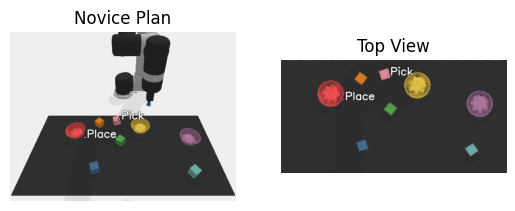

Annotation demo.
Query: True
Reward system: 1.000 | Reward novice: 0.000
Total reward system: 1.0 | Total reward novice: 0
Mean system: 1.000 | Mean agent: 0.000


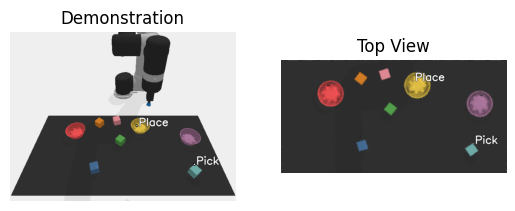

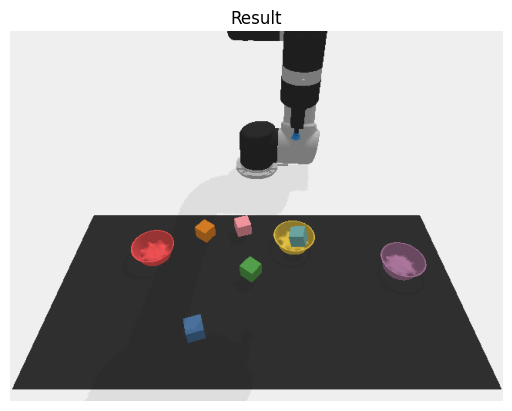


-------------------------------------------------
Interactive demos: 1/20 | Seed: 2
Lang Goal: put the cyan blocks in a blue bowl
Uncertainty: 0.999976 | Threshold: 0.999976


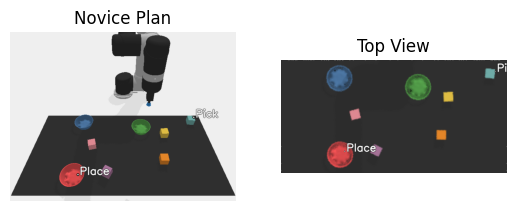

Annotation demo.
Query: True
Reward system: 1.000 | Reward novice: 0.000
Total reward system: 1.0 | Total reward novice: 0
Mean system: 1.000 | Mean agent: 0.000


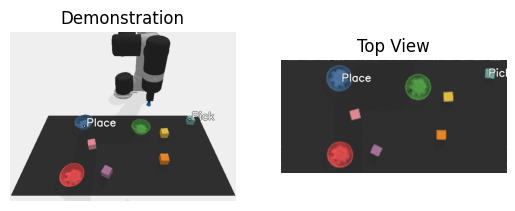

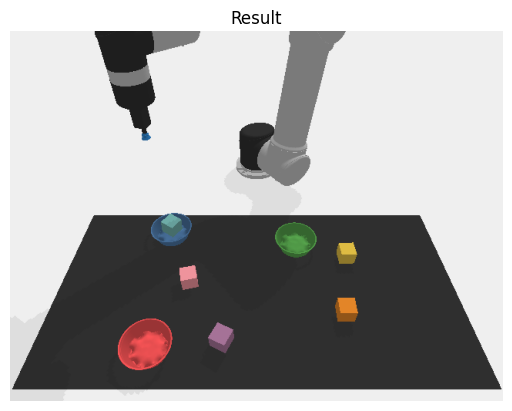


-------------------------------------------------
Interactive demos: 2/20 | Seed: 4
Lang Goal: put the red blocks in a green bowl
Uncertainty: 0.999746 | Threshold: 0.999746


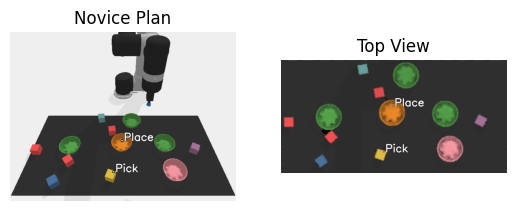

Relabeling demo: put the yellow blocks in a orange bowl
Annotation demo.
Query: True
Reward system: 0.333 | Reward novice: 0.000
Total reward system: 0.3333333333333333 | Total reward novice: 0


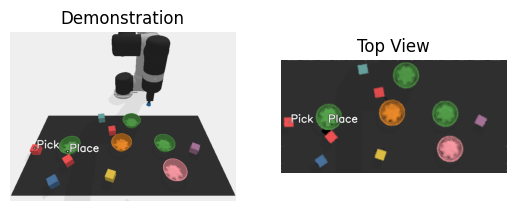

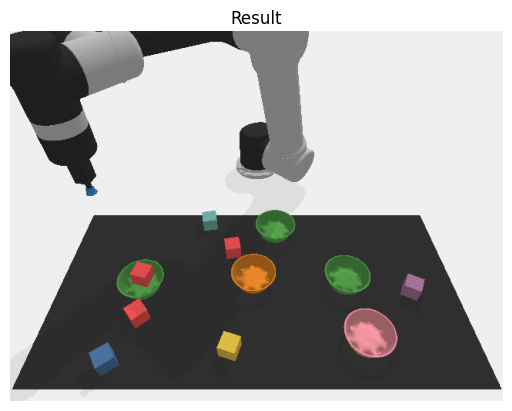

Lang Goal: put the red blocks in a green bowl
Uncertainty: 0.999735 | Threshold: 0.999735


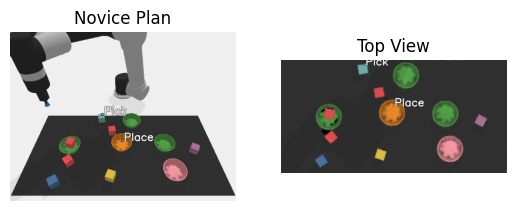

Relabeling demo: put the cyan blocks in a orange bowl
Annotation demo.
Query: True
Reward system: 0.333 | Reward novice: 0.000
Total reward system: 0.6666666666666666 | Total reward novice: 0.0


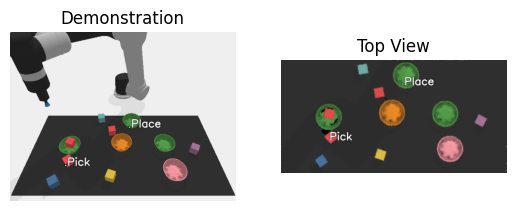

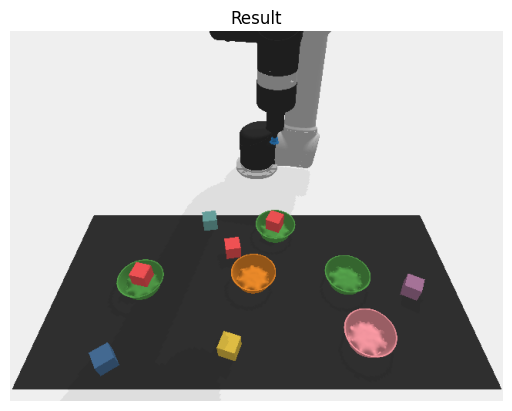

Lang Goal: put the red blocks in a green bowl
Uncertainty: 0.999732 | Threshold: 0.999732


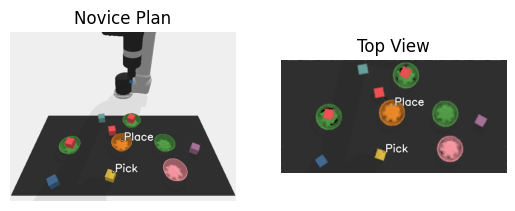

Relabeling demo: put the yellow blocks in a orange bowl
Annotation demo.
Query: True
Reward system: 0.333 | Reward novice: 0.000
Total reward system: 1.0 | Total reward novice: 0.0
Mean system: 1.000 | Mean agent: 0.000


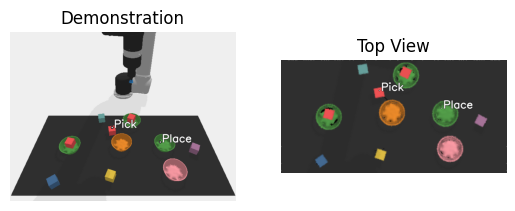

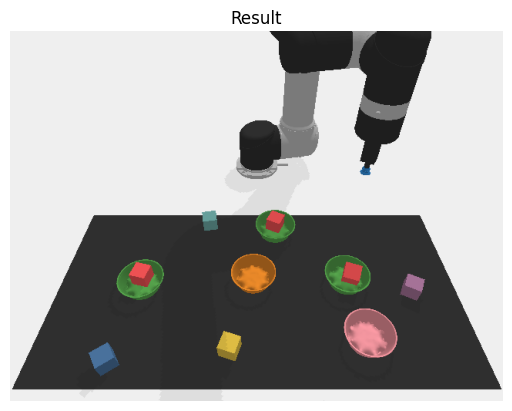


-------------------------------------------------
Interactive demos: 3/20 | Seed: 6
Lang Goal: put the cyan blocks in a brown bowl
Uncertainty: 0.998260 | Threshold: 0.998260


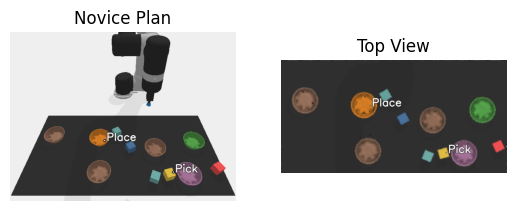

Relabeling demo: put the yellow blocks in a orange bowl
Annotation demo.
Query: True
Reward system: 0.500 | Reward novice: 0.000
Total reward system: 0.5 | Total reward novice: 0


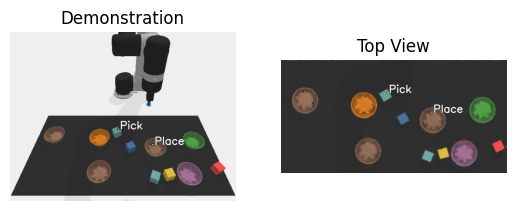

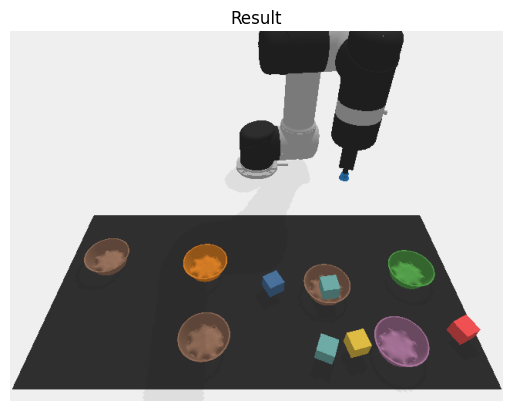

Lang Goal: put the cyan blocks in a brown bowl
Uncertainty: 0.998293 | Threshold: 0.998260


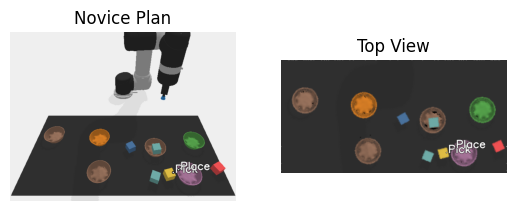

Annotation demo.
Query: True
Reward system: 0.500 | Reward novice: 0.000
Total reward system: 1.0 | Total reward novice: 0.0
Mean system: 1.000 | Mean agent: 0.000


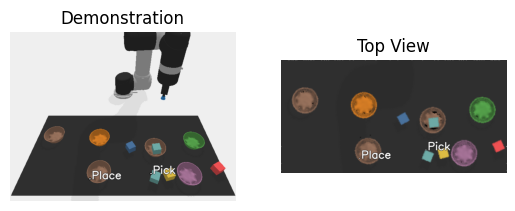

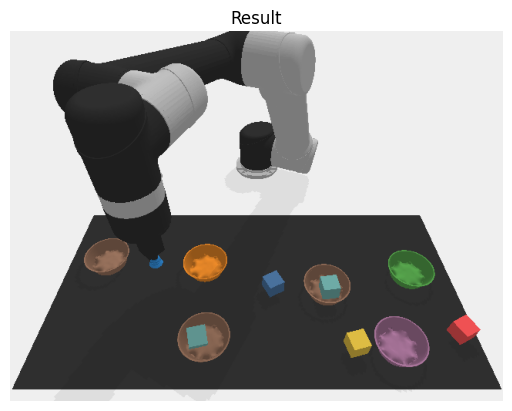


-------------------------------------------------
Interactive demos: 4/20 | Seed: 8
Lang Goal: put the red blocks in a green bowl
Uncertainty: 0.986924 | Threshold: 0.986924


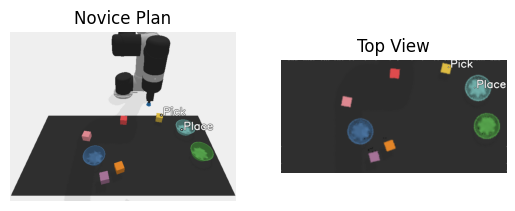

Relabeling demo: put the yellow blocks in a cyan bowl
Annotation demo.
Query: True
Reward system: 1.000 | Reward novice: 0.000
Total reward system: 1.0 | Total reward novice: 0
Mean system: 1.000 | Mean agent: 0.000


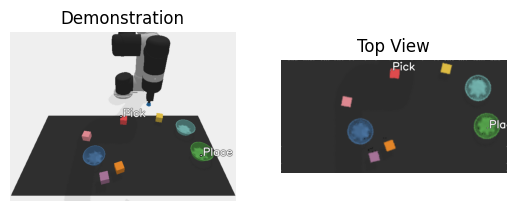

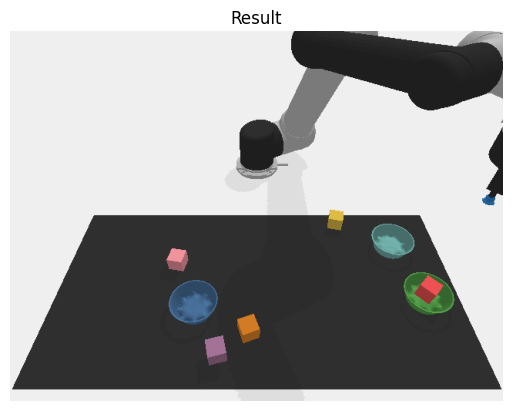


-------------------------------------------------
Interactive demos: 5/20 | Seed: 10
Lang Goal: put the brown blocks in a blue bowl
Uncertainty: 0.956261 | Threshold: 0.956261


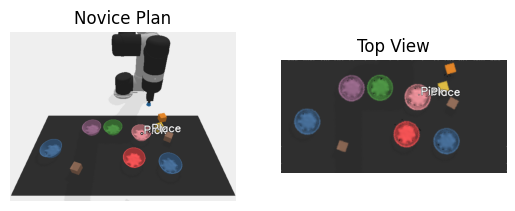

Annotation demo.
Query: True
Reward system: 0.500 | Reward novice: 0.000
Total reward system: 0.5 | Total reward novice: 0


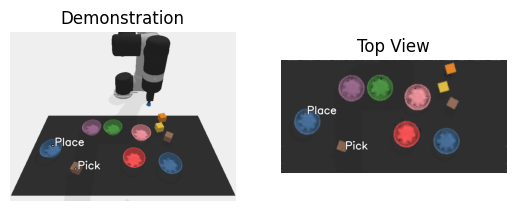

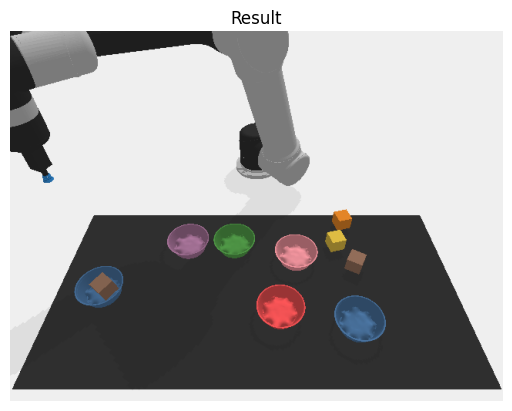

Lang Goal: put the brown blocks in a blue bowl
Uncertainty: 0.956376 | Threshold: 0.956261


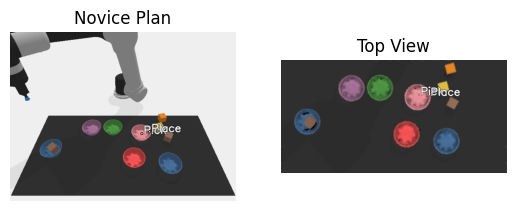

Annotation demo.
Query: True
Reward system: 0.500 | Reward novice: 0.000
Total reward system: 1.0 | Total reward novice: 0.0
Mean system: 1.000 | Mean agent: 0.000


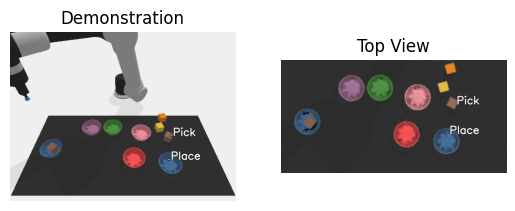

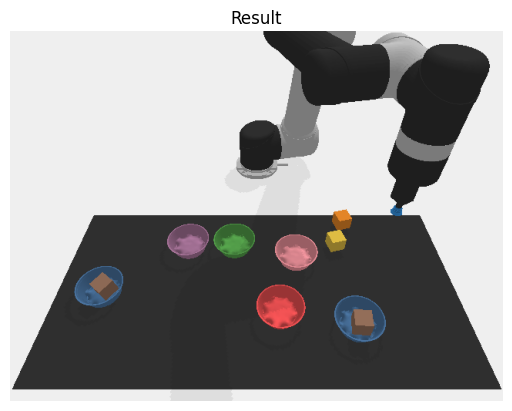


-------------------------------------------------
Interactive demos: 6/20 | Seed: 12
Lang Goal: put the yellow blocks in a green bowl
Uncertainty: 0.910706 | Threshold: 0.910706


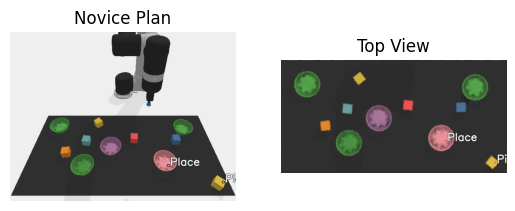

Relabeling demo: put the yellow blocks in a pink bowl
Annotation demo.
Query: True
Reward system: 0.500 | Reward novice: 0.000
Total reward system: 0.5 | Total reward novice: 0


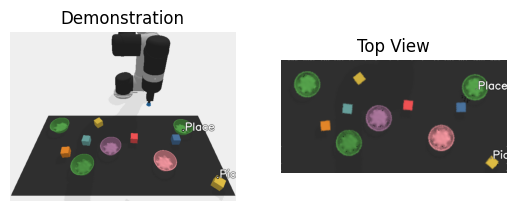

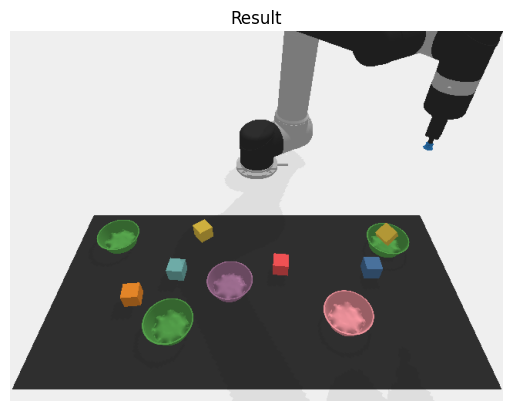

Lang Goal: put the yellow blocks in a green bowl
Uncertainty: 0.856844 | Threshold: 0.856844


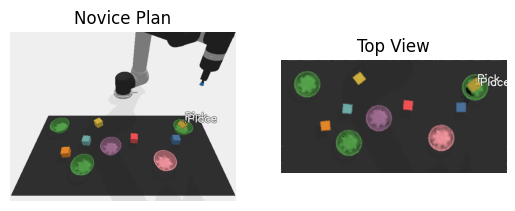

Annotation demo.
Query: True
Reward system: 0.500 | Reward novice: 0.000
Total reward system: 1.0 | Total reward novice: 0.0
Mean system: 1.000 | Mean agent: 0.000


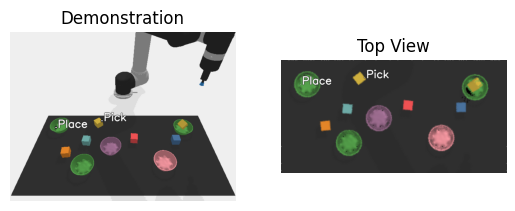

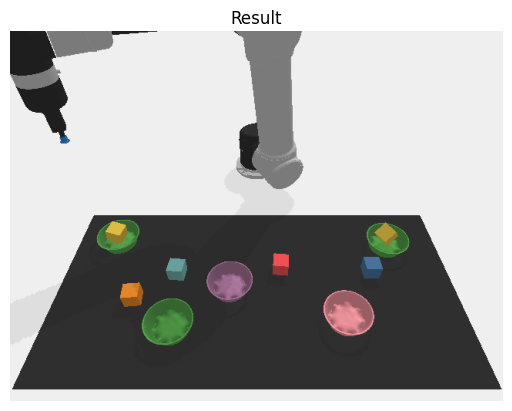


-------------------------------------------------
Interactive demos: 7/20 | Seed: 14
Lang Goal: put the blue blocks in a brown bowl
Uncertainty: 0.615135 | Threshold: 0.615135


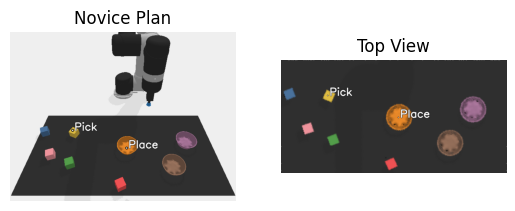

Relabeling demo: put the yellow blocks in a orange bowl
Annotation demo.
Query: True
Reward system: 1.000 | Reward novice: 0.000
Total reward system: 1.0 | Total reward novice: 0
Mean system: 1.000 | Mean agent: 0.000


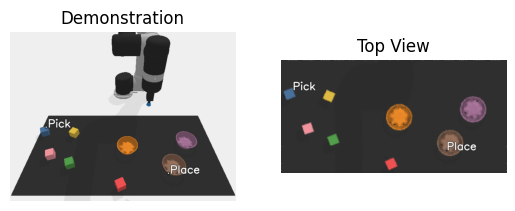

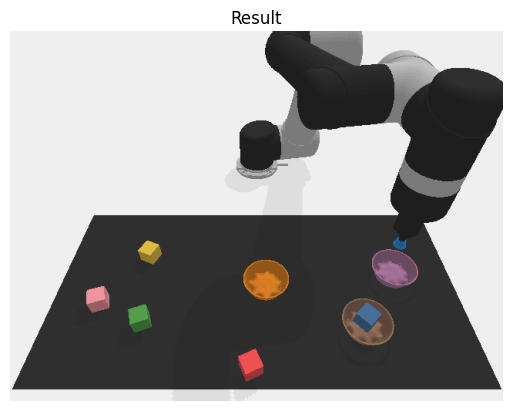


-------------------------------------------------
Interactive demos: 8/20 | Seed: 16
Lang Goal: put the green blocks in a yellow bowl
Uncertainty: 0.855832 | Threshold: 0.615135


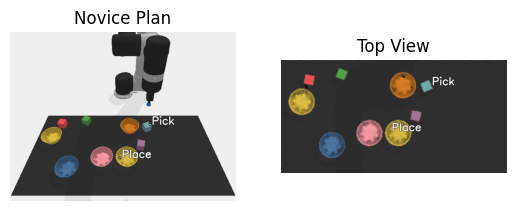

Relabeling demo: put the cyan blocks in a yellow bowl
Annotation demo.
Query: True
Reward system: 1.000 | Reward novice: 0.000
Total reward system: 1.0 | Total reward novice: 0
Mean system: 1.000 | Mean agent: 0.000


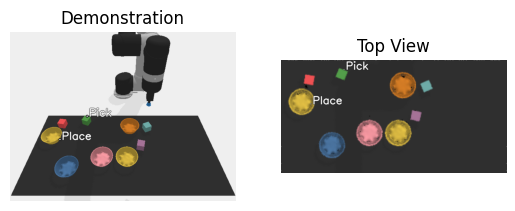

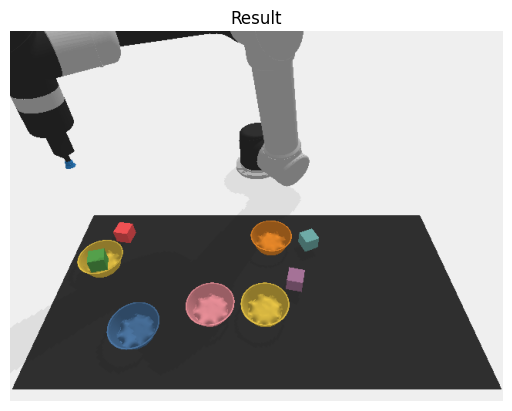


-------------------------------------------------
Interactive demos: 9/20 | Seed: 18
Lang Goal: put the red blocks in a blue bowl
Uncertainty: 0.746229 | Threshold: 0.615135


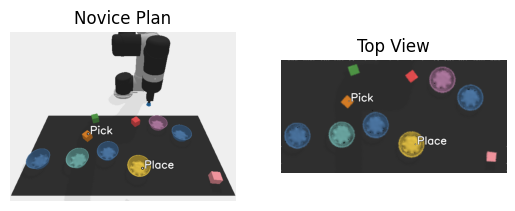

Relabeling demo: put the orange blocks in a yellow bowl
Annotation demo.
Query: True
Reward system: 1.000 | Reward novice: 0.000
Total reward system: 1.0 | Total reward novice: 0
Mean system: 1.000 | Mean agent: 0.000


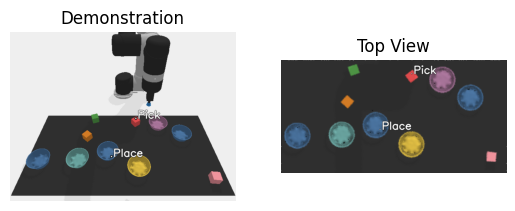

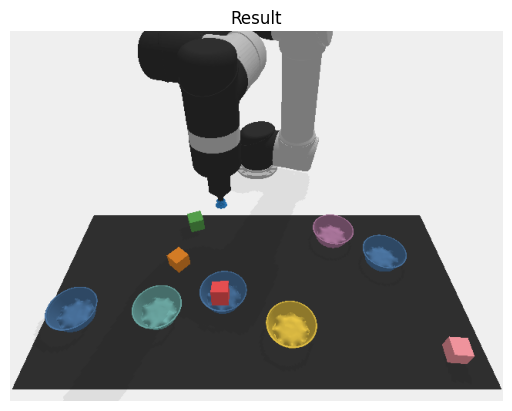


-------------------------------------------------
Interactive demos: 10/20 | Seed: 20
Lang Goal: put the gray blocks in a cyan bowl
Uncertainty: 0.588254 | Threshold: 0.588254


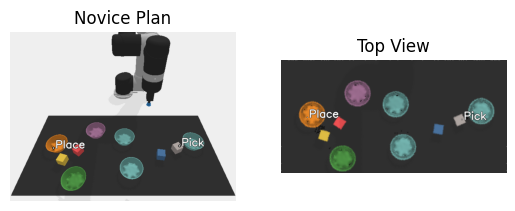

Annotation demo.
Query: True
Reward system: 1.000 | Reward novice: 0.000
Total reward system: 1.0 | Total reward novice: 0
Mean system: 1.000 | Mean agent: 0.000


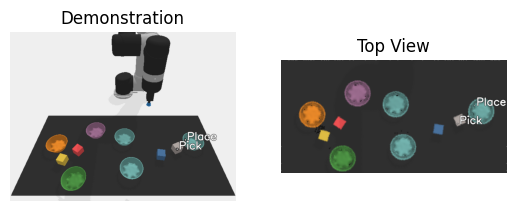

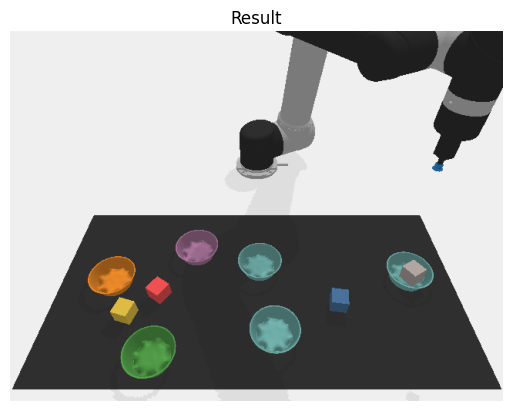


-------------------------------------------------
Interactive demos: 11/20 | Seed: 22
Lang Goal: put the red blocks in a cyan bowl
Uncertainty: 0.603340 | Threshold: 0.588254


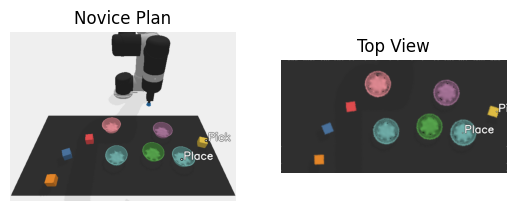

Relabeling demo: put the yellow blocks in a cyan bowl
Annotation demo.
Query: True
Reward system: 1.000 | Reward novice: 0.000
Total reward system: 1.0 | Total reward novice: 0
Mean system: 1.000 | Mean agent: 0.000


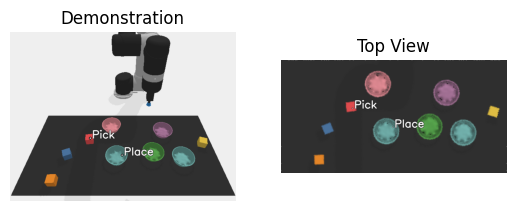

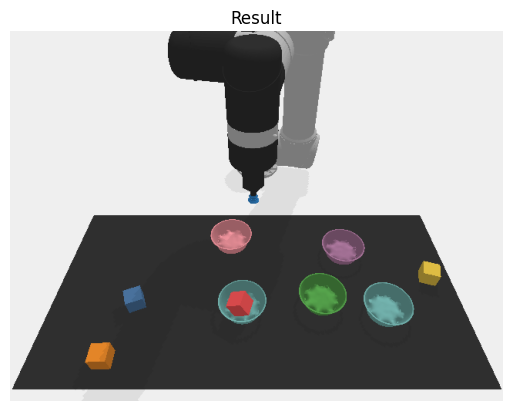


-------------------------------------------------
Interactive demos: 12/20 | Seed: 24
Lang Goal: put the gray blocks in a yellow bowl
Uncertainty: 0.686044 | Threshold: 0.588254


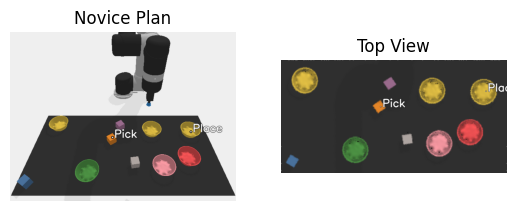

Relabeling demo: put the orange blocks in a yellow bowl
Annotation demo.
Query: True
Reward system: 1.000 | Reward novice: 0.000
Total reward system: 1.0 | Total reward novice: 0
Mean system: 1.000 | Mean agent: 0.000


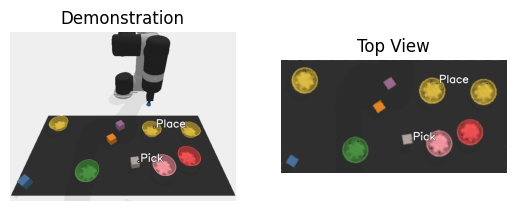

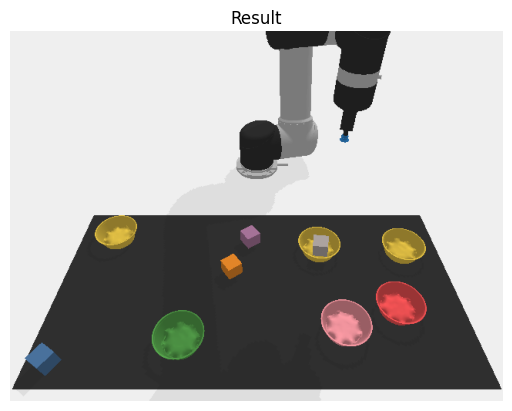


-------------------------------------------------
Interactive demos: 13/20 | Seed: 26
Lang Goal: put the gray blocks in a red bowl
Uncertainty: 0.859634 | Threshold: 0.588254


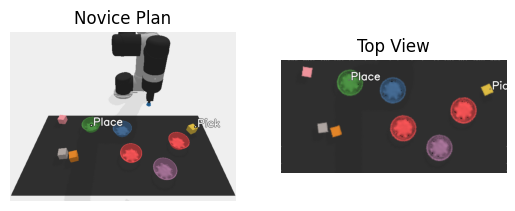

Relabeling demo: put the yellow blocks in a green bowl
Annotation demo.
Query: True
Reward system: 1.000 | Reward novice: 0.000
Total reward system: 1.0 | Total reward novice: 0
Mean system: 1.000 | Mean agent: 0.000


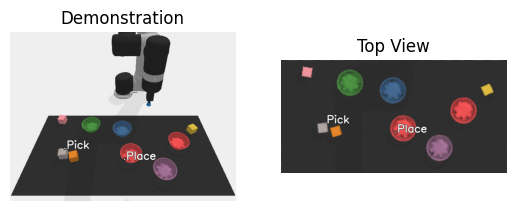

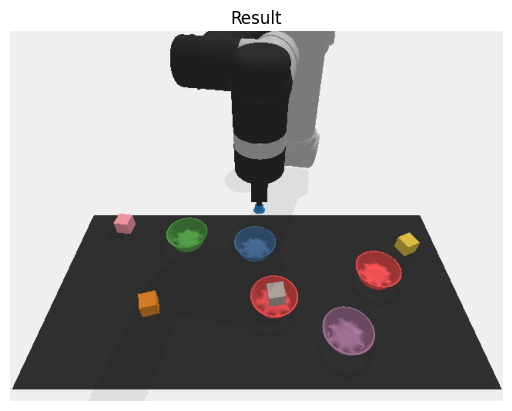


-------------------------------------------------
Interactive demos: 14/20 | Seed: 28
Lang Goal: put the blue blocks in a gray bowl
Uncertainty: 0.756459 | Threshold: 0.588254


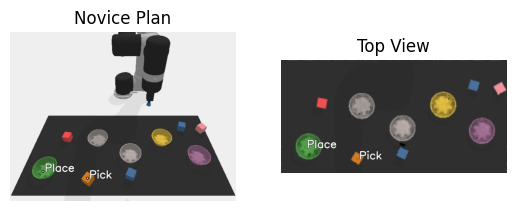

Relabeling demo: put the orange blocks in a green bowl
Annotation demo.
Query: True
Reward system: 0.500 | Reward novice: 0.000
Total reward system: 0.5 | Total reward novice: 0


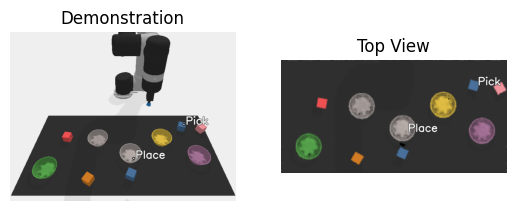

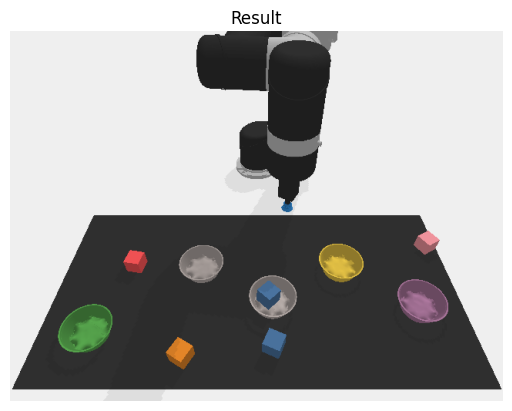

Lang Goal: put the blue blocks in a gray bowl
Uncertainty: 0.748593 | Threshold: 0.588254


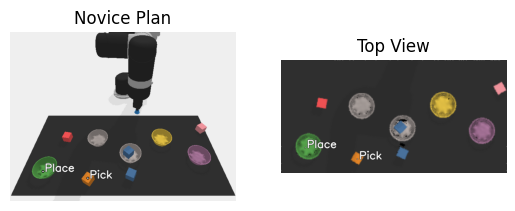

Relabeling demo: put the orange blocks in a green bowl
Annotation demo.
Query: True
Reward system: 0.500 | Reward novice: 0.000
Total reward system: 1.0 | Total reward novice: 0.0
Mean system: 1.000 | Mean agent: 0.000


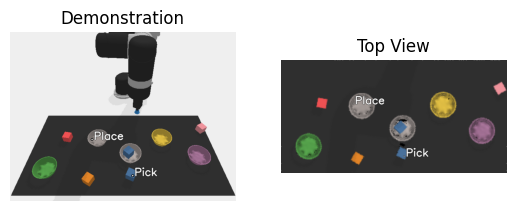

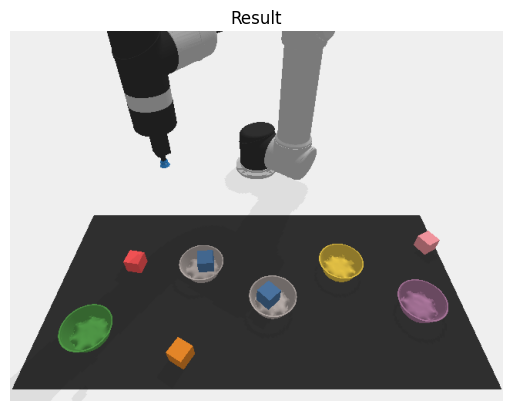


-------------------------------------------------
Interactive demos: 15/20 | Seed: 30
Lang Goal: put the brown blocks in a green bowl
Uncertainty: 0.688267 | Threshold: 0.588254


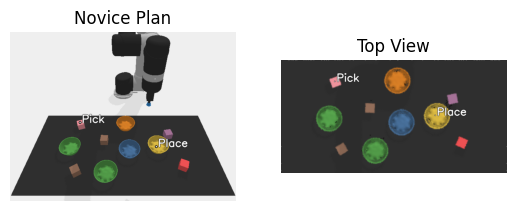

Relabeling demo: put the pink blocks in a yellow bowl
Annotation demo.
Query: True
Reward system: 0.500 | Reward novice: 0.000
Total reward system: 0.5 | Total reward novice: 0


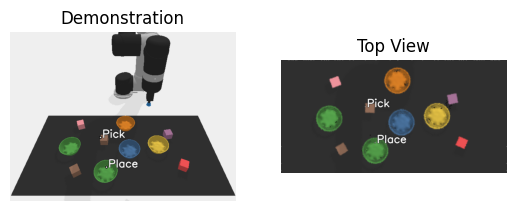

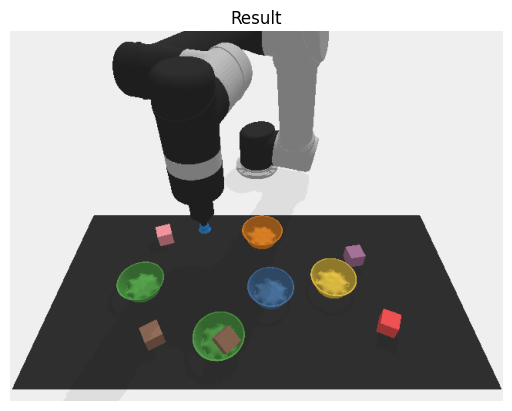

Lang Goal: put the brown blocks in a green bowl
Uncertainty: 0.776118 | Threshold: 0.588254


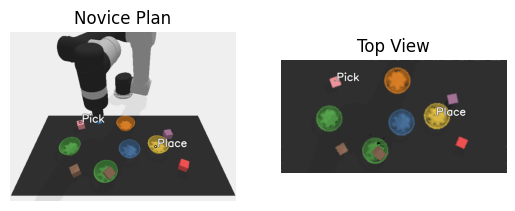

Relabeling demo: put the pink blocks in a yellow bowl
Annotation demo.
Query: True
Reward system: 0.500 | Reward novice: 0.000
Total reward system: 1.0 | Total reward novice: 0.0
Mean system: 1.000 | Mean agent: 0.000


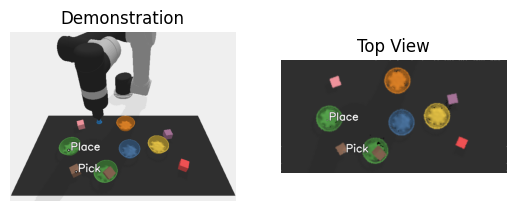

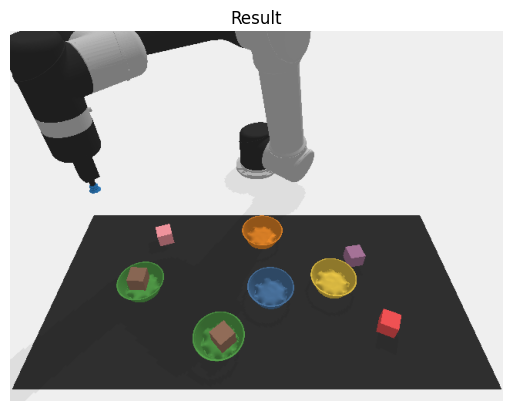


-------------------------------------------------
Interactive demos: 16/20 | Seed: 32
Lang Goal: put the blue blocks in a red bowl
Uncertainty: 0.590183 | Threshold: 0.588254


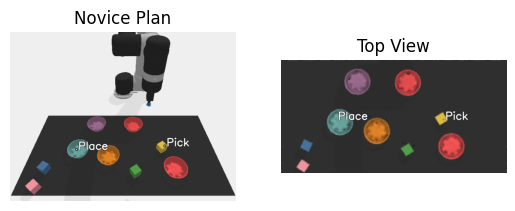

Annotation demo.
Query: True
Reward system: 1.000 | Reward novice: 0.000
Total reward system: 1.0 | Total reward novice: 0
Mean system: 1.000 | Mean agent: 0.000


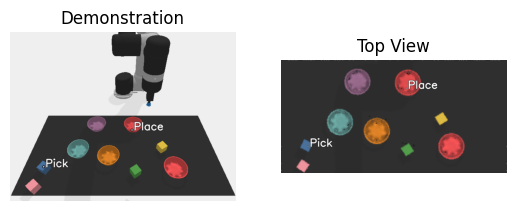

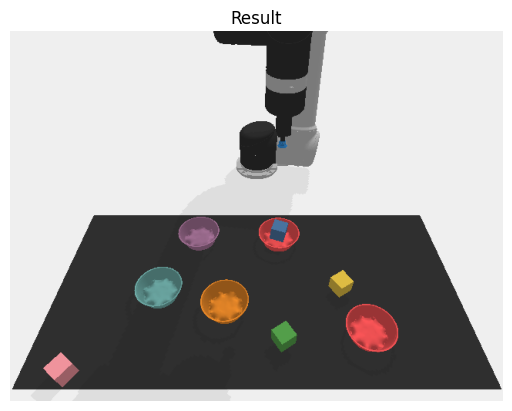


-------------------------------------------------
Interactive demos: 17/20 | Seed: 34
Lang Goal: put the brown blocks in a green bowl
Uncertainty: 0.718898 | Threshold: 0.588254


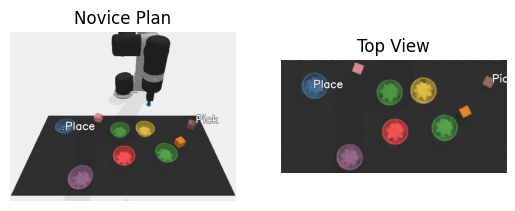

Relabeling demo: put the brown blocks in a blue bowl
Annotation demo.
Query: True
Reward system: 1.000 | Reward novice: 0.000
Total reward system: 1.0 | Total reward novice: 0
Mean system: 1.000 | Mean agent: 0.000


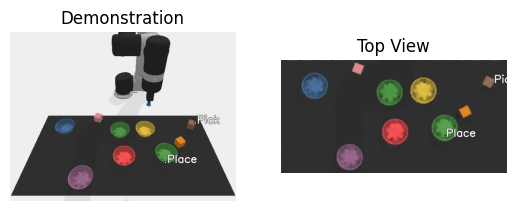

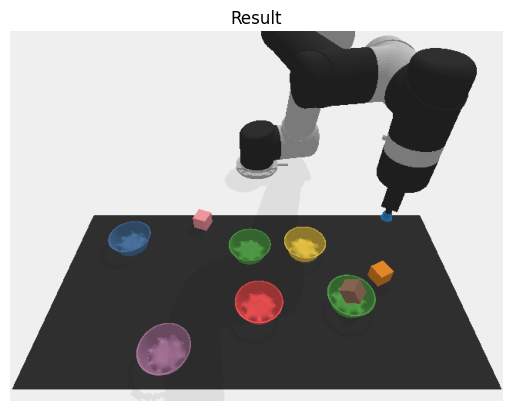


-------------------------------------------------
Interactive demos: 18/20 | Seed: 36
Lang Goal: put the green blocks in a blue bowl
Uncertainty: 0.655277 | Threshold: 0.588254


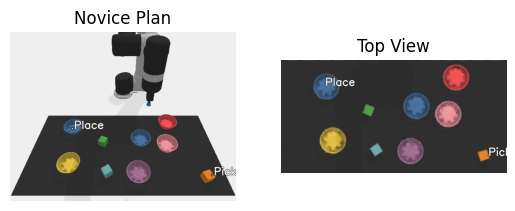

Relabeling demo: put the orange blocks in a blue bowl
Annotation demo.
Query: True
Reward system: 1.000 | Reward novice: 0.000
Total reward system: 1.0 | Total reward novice: 0
Mean system: 1.000 | Mean agent: 0.000


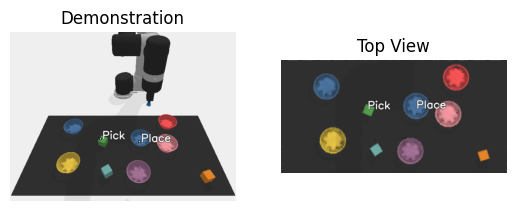

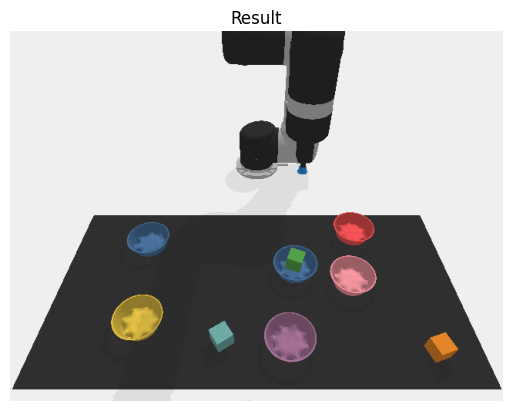


-------------------------------------------------
Interactive demos: 19/20 | Seed: 38
Lang Goal: put the gray blocks in a yellow bowl
Uncertainty: 0.487890 | Threshold: 0.487890


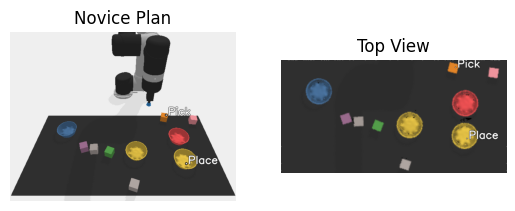

Relabeling demo: put the orange blocks in a yellow bowl
Annotation demo.
Query: True
Reward system: 0.500 | Reward novice: 0.000
Total reward system: 0.5 | Total reward novice: 0


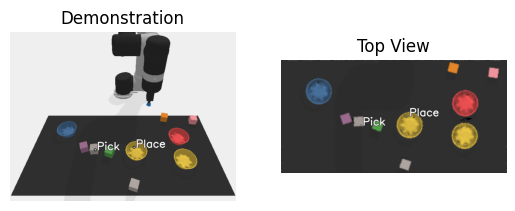

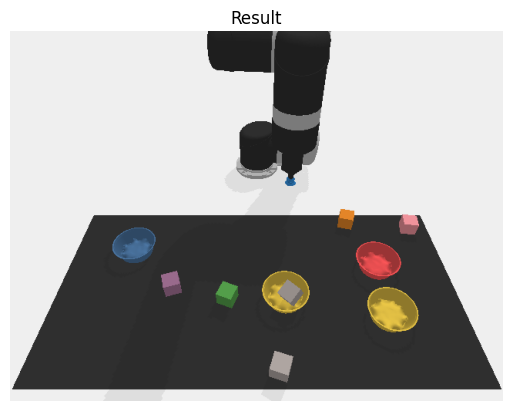

Lang Goal: put the gray blocks in a yellow bowl
Uncertainty: 0.490332 | Threshold: 0.487890


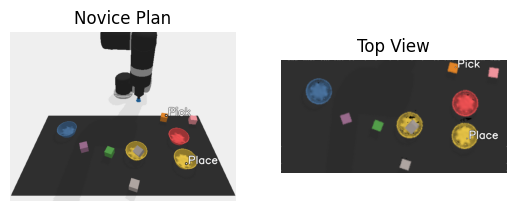

Relabeling demo: put the orange blocks in a yellow bowl
Annotation demo.
Query: True
Reward system: 0.500 | Reward novice: 0.000
Total reward system: 1.0 | Total reward novice: 0.0
Mean system: 1.000 | Mean agent: 0.000


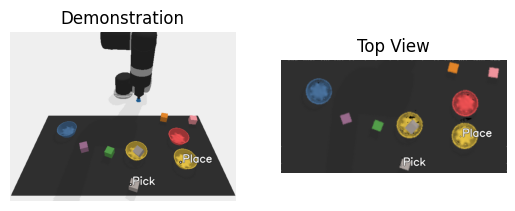

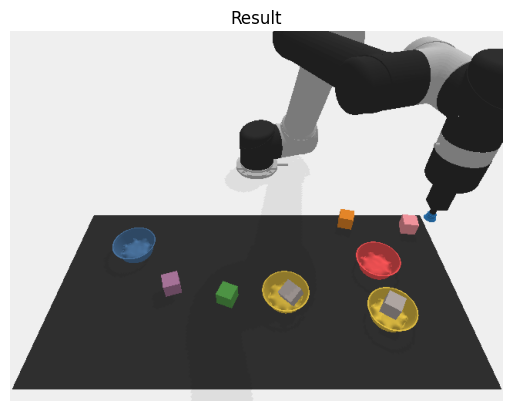

In [ ]:
while interactive_agent.n_interactive < n_demonstrations:
    seed += 2
    interactive_agent.seed = seed

    # Set seeds.
    utils.set_seed(seed)
    print("\n-------------------------------------------------\nInteractive demos: {}/{} | Seed: {}".format(interactive_agent.n_interactive, icfg["interactive_demos"], seed))

    task.mode = "train"
    obs, info = env.reset(seed=seed)
    D_i = []
    reward = 0
    for _ in range(task.max_steps):
        lang_goal = info["lang_goal"]
        print(f"Lang Goal: {lang_goal}")

        # Get agent action.
        if len(obs["color"]) == 0:
            obs = env.get_obs()  # Only rendering when the agent acts, since rendering is slow.
        agent_act, query = interactive_agent.act(obs, info)

        # Visualize the novice's planned action
        obs_copy = deepcopy(obs)
        info_copy = deepcopy(info)
        img, projected_img = interactive_agent.visualize_action(agent_act, obs_copy, info_copy)
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(img)
        ax[0].axis("off")
        ax[0].set_title("Novice Plan")
        ax[1].imshow(projected_img)
        ax[1].axis("off")
        ax[1].set_title("Top View")
        plt.show()

        # Query oracle if uncertainty is high.
        env, obs, reward, terminated, truncated, info, demo = collect_demo(
            obs=obs,
            reward=reward,
            info=info,
            env=env,
            agent_act=agent_act,
            query=query,
            interactive_agent=interactive_agent,
            relabeling_demos=FIER,
            validation_demos=FIER,
            p_rand=icfg["train_interactive"]["p_rand"],
        )
        done = terminated or truncated
        interactive_agent.update_stats(demo)

        # Rewards are privileged information, so we update it separately.
        # We only use this information for logging purposes
        interactive_agent.update_rewards(done, novice_reward=demo["novice_reward"], system_reward=reward)

        if demo["demo"] is not None:
            D_i.append(demo["demo"])
            if demo["oracle_demo"]:
                act = demo["demo"][1]

                # Visualize demonstration
                img, projected_img = interactive_agent.visualize_action(act, obs_copy, info_copy)
                fig, ax = plt.subplots(1, 2)
                ax[0].imshow(img)
                ax[0].axis("off")
                ax[0].set_title("Demonstration")
                ax[1].imshow(projected_img)
                ax[1].axis("off")
                ax[1].set_title("Top View")
                plt.show()

        if demo["relabeling_demo"] is not None:
            D_i.append(demo["relabeling_demo"])

        # Visualize environment after taking the action
        plt.title("Result")
        plt.imshow(env.render())
        plt.axis("off")
        plt.show()

        if done:
            break

    if len(D_i) > 0:
        if len(obs["color"]) == 0:
            obs = interactive_agent.get_image(env.get_obs())
        D_i.append((obs, None, reward, info))
        interactive_agent.add_demo(seed, D_i)
        interactive_agent.prioritize_replay()
    interactive_agent.update_model()